# Анализ оттока клиентов из банка

## Описание и задачи 

<b>Цель работы:</b> <br>
Выделить "типовые" портреты уходящих из банка пользователей и предложить рекомандации по их удержанию.<br>
<br>
<b>Описание ситуации:</b><br>
Банк «Метанпром» располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. У банка есть информация о пользователях, в том числе агрегированные показатели и факт "ухода" из банка. Необходимо на основе анализа этих данных выделить портрет клиентов, которые склоны уходить, и предложить рекомандации по работе с ними.<br>
<br>
<b>Какие данные есть в базе, с которой предстоит работать?</b><br>
<br>
'userid' — идентификатор пользователя,<br>
'score' — баллы кредитного скоринга,<br>
'City' — город,<br>
'Gender' — пол,<br>
'Age' — возраст,<br>
'Objects' — количество объектов в собственности,<br>
'Balance' — баланс на счёте,<br>
Products — количество продуктов, которыми пользуется клиент,<br>
CreditCard — есть ли кредитная карта,<br>
Loyalty — активный клиент,<br>
estimated_salary — заработная плата клиента,<br>
Churn — ушёл или нет.<br>
<br>
<b>Гипотезы, которые будут проверяться в работе:</b><br>
1) Средний уровень дохода у тех клиентов банка, кто остался, отличается от среднего уровня дохода у клиентов банка, которые ушли;<br>
2) Среднее количество продуктов, которыми пользуются клиенты, отличается у группы тех, кто ушел, и группы тех, кто остается с банком.

## Предобработка данных 

In [ ]:
import pandas as pd
from numpy import array 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools 
from scipy import stats as st

In [ ]:
df = pd.read_csv('/datasets/bank_dataset.csv')
df.info()
display(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
6749,15696140,684,Рыбинск,Ж,24,9,79263.90,1,0,1,196574.48,0
6510,15686652,619,Рыбинск,М,46,8,62400.48,1,1,1,132498.39,1
9367,15827760,629,Ярославль,Ж,40,9,137409.19,1,1,0,175877.70,1
3722,15850697,619,Ярославль,М,25,4,NaN,1,1,0,145524.36,0
7060,15637041,712,Ярославль,Ж,32,1,NaN,2,1,0,1703.58,0
6390,15631142,574,Рыбинск,Ж,37,7,NaN,2,1,0,32262.28,0
3970,15677046,509,Ярославль,М,30,6,NaN,2,1,0,180598.86,0
3916,15663012,539,Рыбинск,М,36,6,NaN,3,1,1,118959.64,0
3963,15672339,607,Ярославль,М,31,8,NaN,2,1,1,43196.50,0
4448,15750898,565,Ростов Великий,Ж,40,1,89994.71,2,0,1,121084.27,0


Видно, что в данных есть пропущенные значения. Типы данных соответствуют содержанию. Приведем названия столбцов к единому формату для удобства использования и посмотрим, сколько именно данных пропущено.

In [ ]:
df.columns = df.columns.str.lower()

display(df.isna().sum())
print ('Процент пропущенных значений от общего количества —  {:.2%}'.format(df['balance'].isna().sum() / len(df)))

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Процент пропущенных значений от общего количества —  36.17%


Более трети пропущенных значений в данных о балансе клиентов банка. Вероятно, пропуск — это нулевой баланс. 

In [ ]:
df_isna = df[df['balance'].isna()]
print (df_isna.shape)
display(df_isna.sample(5))

(3617, 12)


,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
1743,15768824,476,Ярославль,М,40,6,NaN,1,1,1,22735.45,0
402,15824325,751,Рыбинск,М,52,8,NaN,2,0,1,179291.85,0
9006,15798854,661,Рыбинск,М,20,8,NaN,1,1,0,110252.53,0
4538,15719571,710,Рыбинск,М,33,1,NaN,2,1,0,168313.17,0
4778,15624982,737,Рыбинск,Ж,45,2,NaN,2,0,1,177695.67,0


Рассмотрим по очереди каждый признак в созданной таблице, где значения баланса отсутствуют.

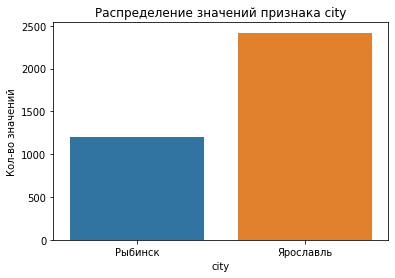

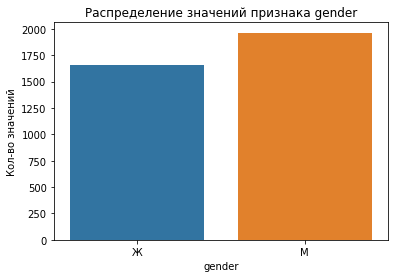

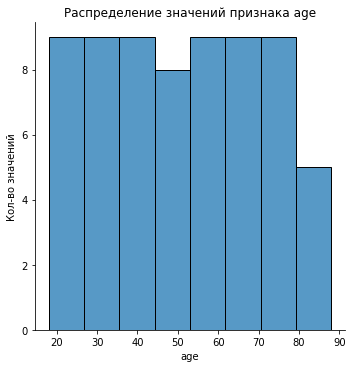

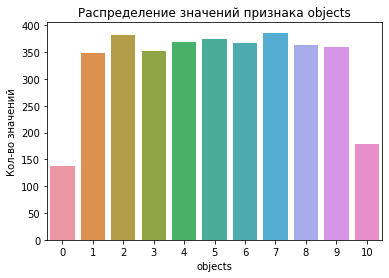

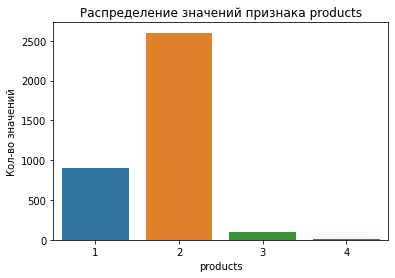

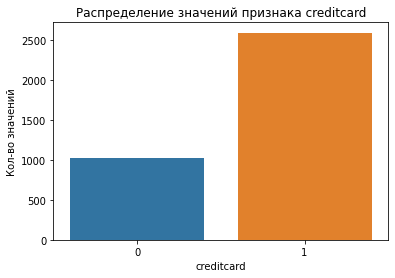

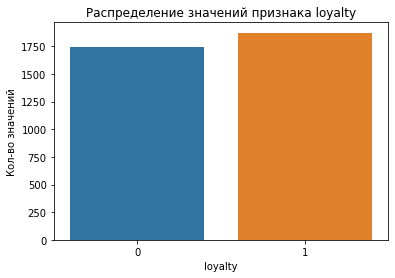

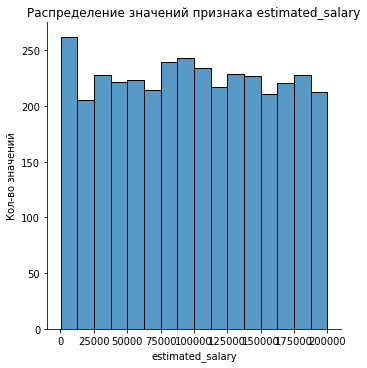

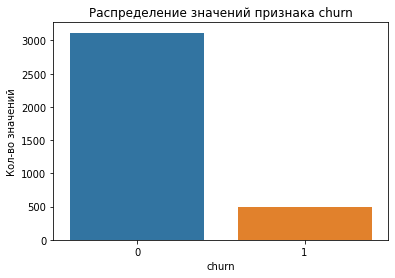

In [ ]:
for col in df_isna.drop(['userid','balance', 'score'], axis=1).columns:
    if len(df[col].unique().tolist())<=12:
        sns.barplot(data=df_isna.pivot_table(
            index=col, 
            values='userid', 
            aggfunc='count')
                    .reset_index(), x=col, y='userid')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()
    else: 
        report=df_isna.pivot_table(
            index=col, 
            values='userid', 
            aggfunc='count').reset_index()
        sns.displot(data=report, x=col)
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()

In [ ]:
#учитвая то, что распределение по городам бросилось в глаза, посмотрим на изначальные количество этой значений
df['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [ ]:
df['creditcard'].value_counts()

1    7055
0    2945
Name: creditcard, dtype: int64

In [ ]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

Из представленной визуализации значений параметров в подтаблице с пропушенных значений в баланке бросается в глаза отсутствие третьего города (Ростова Великого). Возможно, пропуски в данных могут быть связаны с тем, что в конкретных города сбоит система или счета открываются, но на них ничего не хранится. То, что в Ярославле больше людей и так видно из общих значений базы данных. 

При этом можно ответить, что около половины клиентов из Ярославля и Рыбинска имеют пропущенные значения в балансе. Это же касается и оставшихся клиентов банка. Кроме того, можно заметить, что несмотря на то, что клиенты из банка ушли, в системе до сих может находится из счет, ведь только у почти 500 из 2037 ушедших отсутствуют значения в поле баланса<br>
<br>
Проверим это, изучив, есть ли значения 0 в балансе клентов.

In [ ]:
print ('Количество значений признака баланса равное нулю — {0}'.format(df[df['balance']==0]['userid'].count()))

Количество значений признака баланса равное нулю — 0


Итак, пропущенные значения с большой вероятностью можно считать за нулевой баланс на карте клиента. Вероятно, пропуски появились:<br>
- или из-за того, что клиенты появились недавно и поэтому их счет ещё не активировали и там ничего нет. Но тогда не понятно, как клиент мог уже совершить какое-то действие (признак лояльности) и даже уйти из банка).
- или из-за проблем в системе, которая считает 0 на счету — как то, что нет денег (что в целом логично). Однако тогда получается, что у более 30% (и оставшихся, и ушедших) клиентов банка на балансе счета — 0. <br>
<br>
Необходимо проверить дополнительно то, как данные попадают в признак баланса. Например, запросив данные об открытии клиентов счета в банке.<br>
Оставим пока что эти данные нетронутыми. Всё-таки 36% данных заполнять на нули перед исследовательским анализом — не самая хорошая идея.

Проверим наличие дубликатов в данных, сравнив userid

In [ ]:
df['userid'].duplicated().sum()

0

Мы подготовили данные для анализа, заменив названия столбцов, проверили пропуски и дубликаты в данных.

## Исследовательский анализ данных 

Теперь проведем исследовательский анализ данных, чтобы проверить наличие выбросов, распределение данных и их описателные статистики. Для начала изучим, сколько % клиентов ушло

In [ ]:
df.drop('userid', axis=1).describe()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Среднестатистический клиент банка — это мужчина из Ярославля, в возрасте около 39 лет, у которого 5 объектов собственности. Он пользуется 1-2 продуктами банка, в том числе кредитной карточкой. На банковском балансе у него около 120 тысяч, при том, что зарабатывает он около 100 тыс. 

Рассмотрим распределения данных в разрезах по полу и городам

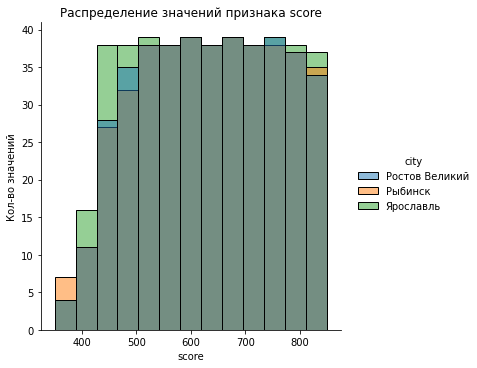

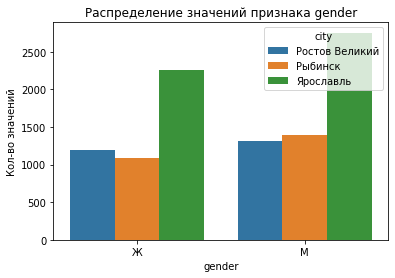

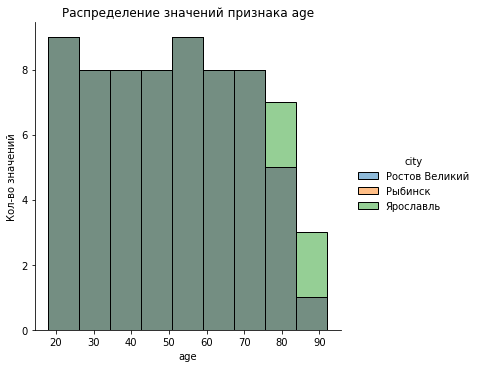

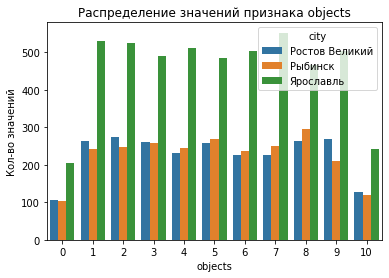

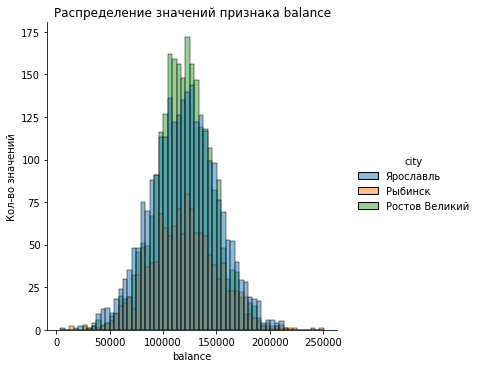

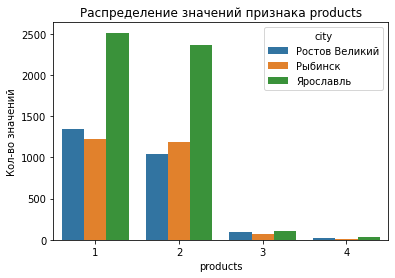

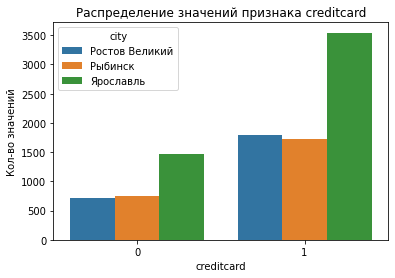

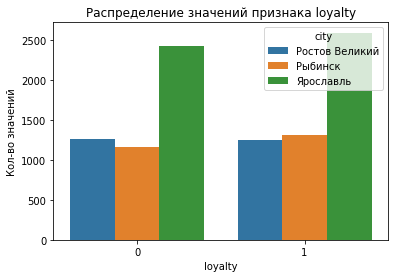

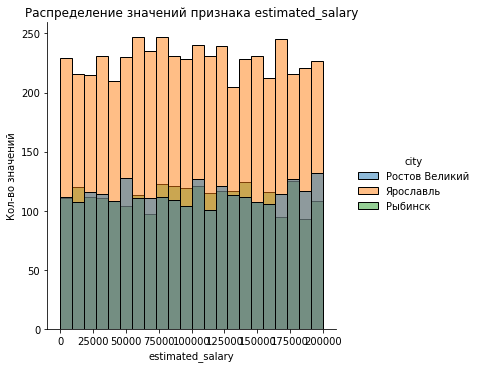

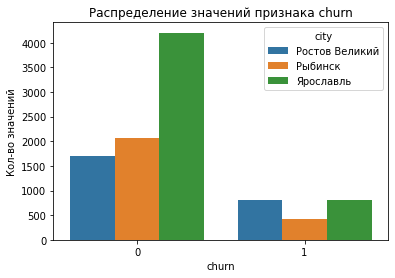

In [ ]:
for col in df.drop(['userid', 'city'], axis=1).columns:
    if len(df[col].unique().tolist())<=12:
        sns.barplot(data=df.pivot_table(
            index=[col, 'city'], 
            values='userid', 
            aggfunc='count')
                    .reset_index(), x=col, y='userid', hue='city')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()
    else: 
        report=df.pivot_table(
            index=[col, 'city'], 
            values='userid', 
            aggfunc='count').reset_index()
        sns.displot(data=report, x=col, hue='city')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()

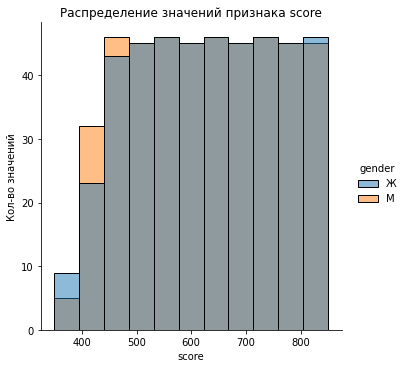

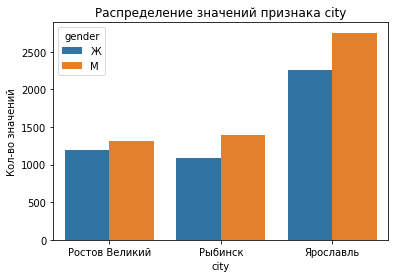

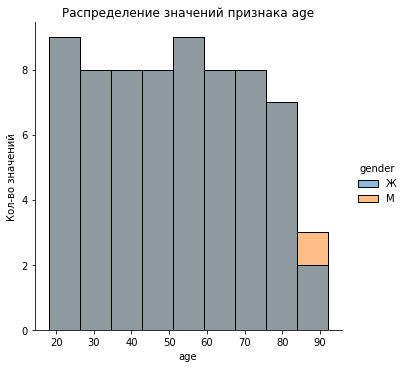

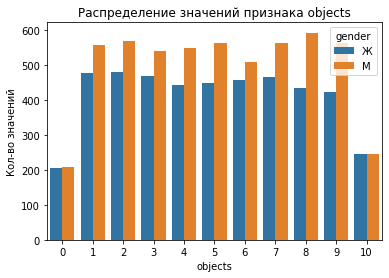

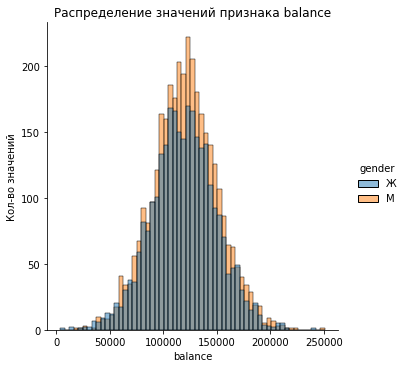

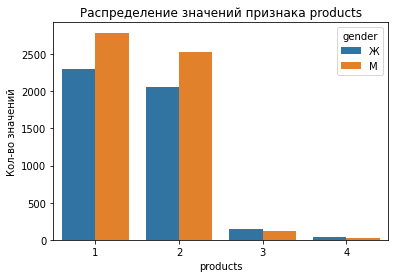

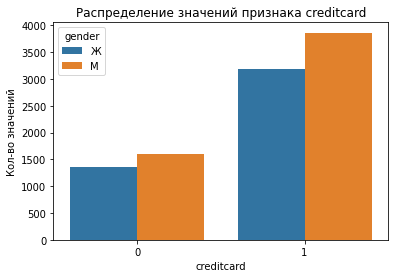

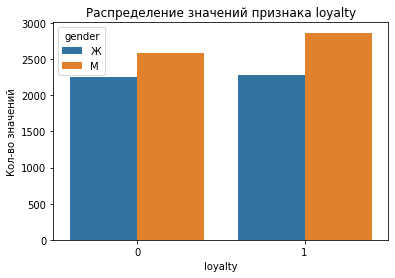

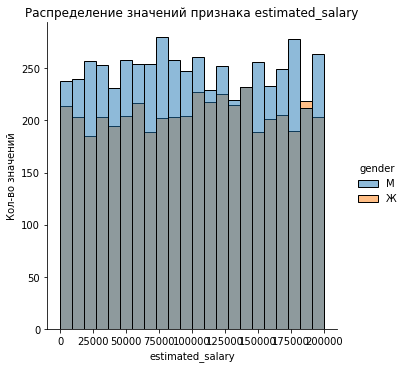

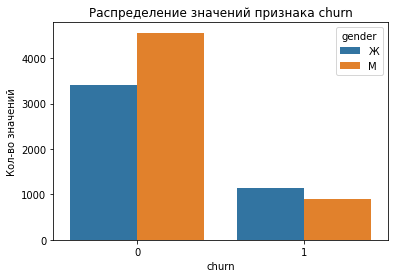

In [ ]:
for col in df.drop(['userid', 'gender'], axis=1).columns:
    if len(df[col].unique().tolist())<=12:
        sns.barplot(data=df.pivot_table(
            index=[col, 'gender'], 
            values='userid', 
            aggfunc='count')
                    .reset_index(), x=col, y='userid', hue='gender')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()
    else: 
        report=df.pivot_table(
            index=[col, 'gender'], 
            values='userid', 
            aggfunc='count').reset_index()
        sns.displot(data=report, x=col, hue='gender')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()

Рассмотрев данные в разрезах по городам и полу, 

- клиентов плохим скорингом больше всего в Рыбинске;
- В Ярославле находится больше пожилых клиентов банка;
- лучше всего с балансом на счету обстоят дела у клиентов из Ростова Великого. Они же отсуствовали среди пропущенных значений баланса;
- уходящих клиентов из Ярославля и Ростова Великого почти одинаковое количество, но при этом в последнем городе их общее число в 2 раза меньше, чем кол-во клиентов из Ярослваля;
- женщины чаще пользуются 3-4 продуктами банка;
- женщины чаще мужчин уходят как клиенты из банка (даже при том, что их меньше, чем мужчин);

In [ ]:
print ('Процент клиентов, ушедших из банка: {:.1%}'.format(df[df['churn']==1]['churn'].count()/len(df)))

Процент клиентов, ушедших из банка: 20.4%


Уходит каждый пятый клиент

Теперь посмотрим на разницу показателей среди двух групп: ушедших и оставшихся.

In [ ]:
df.drop('userid', axis=1).groupby('churn').mean()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,
0,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


Визуализируем эти данные для наглядности

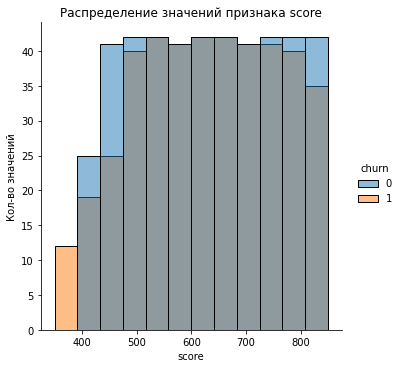

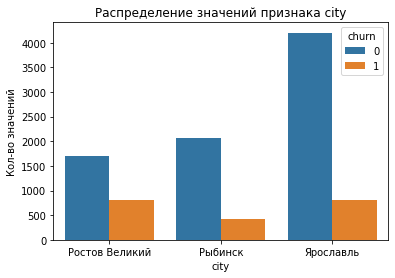

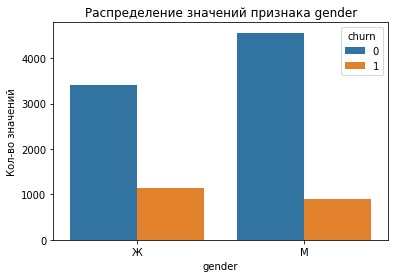

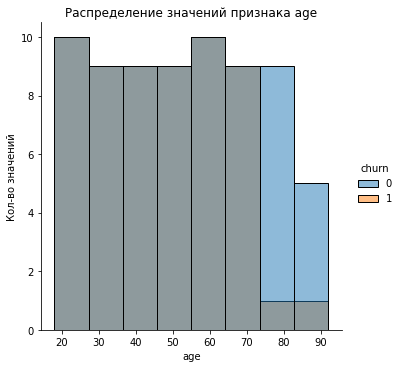

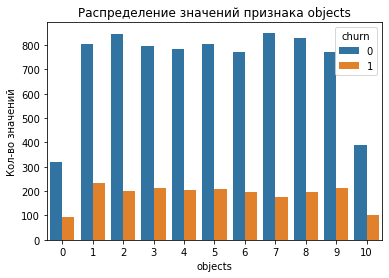

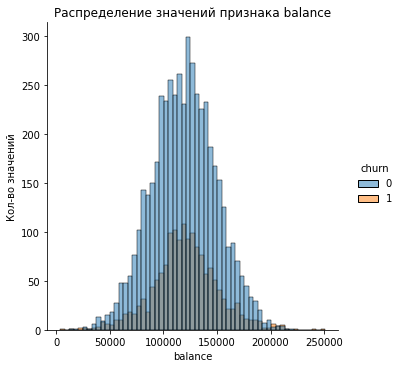

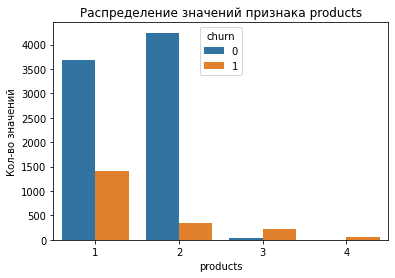

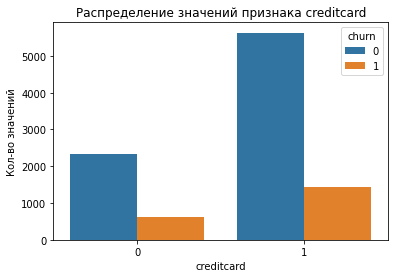

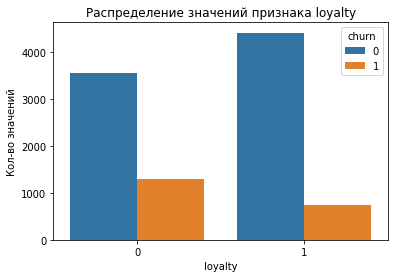

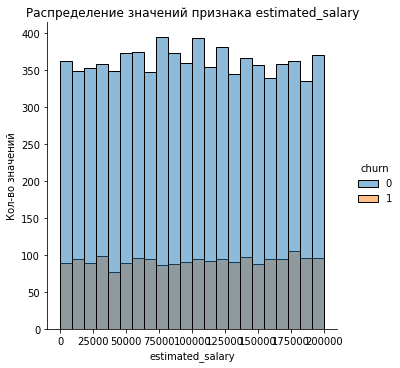

In [ ]:
for col in df.drop(['userid', 'churn'], axis=1).columns:
    if len(df[col].unique().tolist())<=12:
        sns.barplot(data=df.pivot_table(
            index=[col, 'churn'], 
            values='userid', 
            aggfunc='count')
                    .reset_index(), x=col, y='userid', hue='churn')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()
    else: 
        report=df.pivot_table(
            index=[col, 'churn'], 
            values='userid', 
            aggfunc='count').reset_index()
        sns.displot(data=report, x=col, hue='churn')
        plt.title('Распределение значений признака {0}'.format(col))
        plt.ylabel('Кол-во значений')
        plt.show()

Изучая распределение признаков среди оставшихся и ушедших клиентов, можно заметить, что :
- наибольшей отличительной чертой между этими двуями группами является возраст. Среди всех клиентов банка заметно, что молодые люди чаще оказываются среди тех, кто уходит, а более возрастные — чаще остаются. Но при этом средний возраст оставшихся людей меньше, чем у ушедших. Вероятно, это связано с общим количество ушедших и оставшихся;
- в Ростове Великом больше всего в процентном соотношении тех, кто уходит из банка. Цифры на уровне Ярославля, но там и клиентов больше;
- среди тех, не совершал никаких действий и не попадал в категорию лояльных клиентов, большее ушедших людей (хотя такие есть даже среди тех, кто был активным);
- среди тех, кто пользуются кредитными картами, уходит больше людей, чем среди тех, у кого нет кредиток.
- среди тех, кто пользуются 3 или 4 продуктами банка уходящих больше, чем оставшихся клиентов. Это же касается и наблюдений по полу. При этом средние показатели этих параметров различаются не сильно.

Чтобы оценить значимость признаков и их взаимосвязь, построим корреляции, отраженные на тепловой карте

In [ ]:
#так как у нас есть категориальные переменные, для построения корреляций, необходимо их привести в числа
ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(df[['city']])

cities=pd.DataFrame(new_ohe_features, columns=ohe.categories_)
cities.columns = ['rostov', 'rybinsk', 'yaroslavl']
df = df.join (cities)

df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0.0,0.0,1.0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,1.0
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0.0,0.0,1.0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0


In [ ]:
new_ohe_features = ohe.fit_transform(df[['gender']])
genders = pd.DataFrame(new_ohe_features, columns=ohe.categories_)
genders.columns = ['femal', 'male']

df = df.join(genders)
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl,femal,male
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0.0,0.0,1.0,1.0,0.0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0,1.0,0.0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,1.0,1.0,0.0
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0.0,0.0,1.0,1.0,0.0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0,1.0,0.0


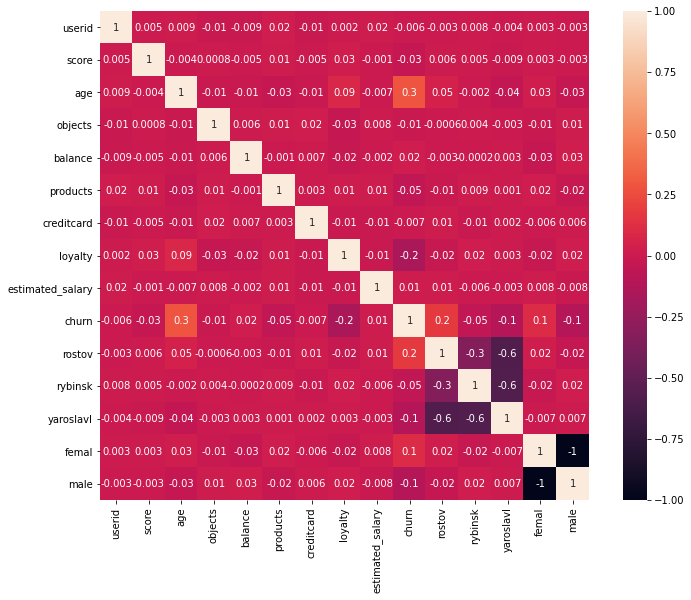

In [ ]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.1g')
plt.show()

Построив матрицу корреляций, мы подтвердили мысль о том, что возраст и лояльность имеют какую-то связь с фактом ухода из банка, так как они выделяются сильнее всего на фоне остальных корреляций.

Как видно из графиков распределения, среди тех клиентов, которые остались в банке, большее людей за 70, в то время как у ушедших, наблюдается лишь несколько выбросов. Кроме того, среди ушедших людей больший разброс в балансах на счете. 

## Изучение портретов ушедших пользователей 

In [ ]:
#заполним пропущенные значения в балансе, чтобы дальше мы могли использовать кластеризацию
df = df.fillna(0)
df[df['balance']==0]['userid'].count()

3617

In [ ]:
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn',
       'rostov', 'rybinsk', 'yaroslavl', 'femal', 'male'],
      dtype='object')

Количество теперь клиентов с нулевым балансом совпадает с количеством пропушенных значений. Теперь мы можем начать изучать профили людей, которые ушли из банка. Для этого применим сначала метода иерархической кластеризации, чтобы оценить, какое количество кластеров мы могли бы создать.

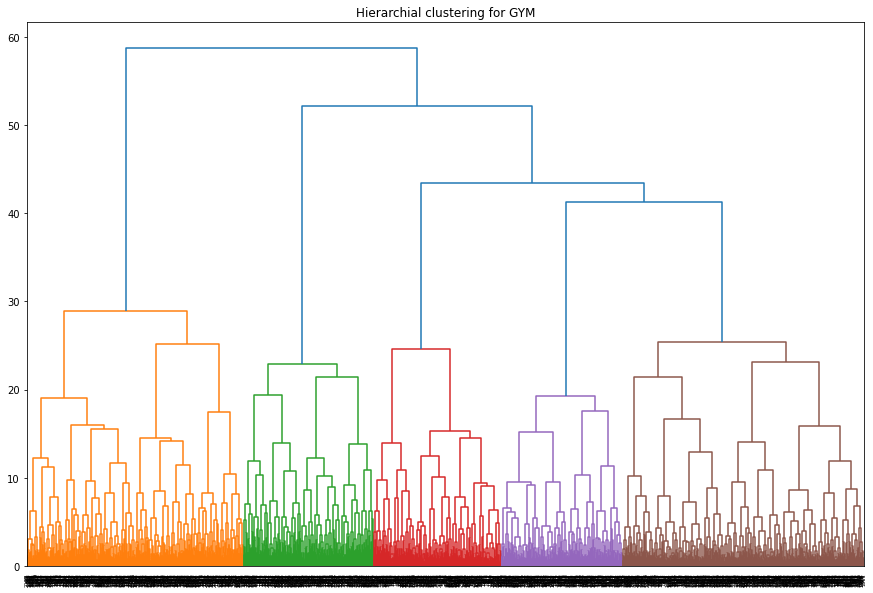

In [ ]:
df_1 = df[df['churn']==1]

#решил убрать признаки, по которым должна строиться кластеризация, данныые о городах и поле. Иначе кластерзация сводилась к тому, что кластеры выделялись на основе города и пола
X = df_1.drop(['userid', 'city', 'gender', 'rostov', 'rybinsk', 'yaroslavl', 'femal', 'male'], axis=1)
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for churning clients')
plt.show() 

Учитывая 5 разных цветов, в дальнейшем мы используем это количество для присвоения номеров кластеров с помощью метода К-средних.

In [ ]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
df_1['labels'] = labels

df_1_grp = df_1.drop(['userid', 'churn'], axis=1).groupby('labels')
display (df_1_grp.mean())
#посмотрим количество ушедших пользователей по кластерам
df_1.groupby('labels')['userid'].count()

/tmp/ipykernel_95/2243966997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['labels'] = labels


,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,rostov,rybinsk,yaroslavl,femal,male
labels,,,,,,,,,,,,,
0,645.675000,44.696429,5.092857,87541.668786,3.214286,0.703571,0.407143,106345.273571,0.392857,0.210714,0.396429,0.596429,0.403571
1,658.986079,45.679814,2.770302,77722.943503,1.167053,1.000000,0.000000,87456.740302,0.341067,0.218097,0.440835,0.535963,0.464037
2,647.615094,45.198113,4.939623,93042.937151,1.211321,0.000000,0.407547,103418.601396,0.392453,0.215094,0.392453,0.549057,0.450943
3,628.785166,43.933504,7.429668,103723.089488,1.189258,1.000000,0.000000,115619.453760,0.468031,0.179028,0.352941,0.554987,0.445013
4,643.649383,44.441975,4.703704,93109.516148,1.222222,1.000000,1.000000,96780.218025,0.409877,0.187654,0.402469,0.575309,0.424691


labels
0    280
1    431
2    530
3    391
4    405
Name: userid, dtype: int64

Визуализуем распределение признаков по кластерам, чтобы лучше разобраться в различии кластеров

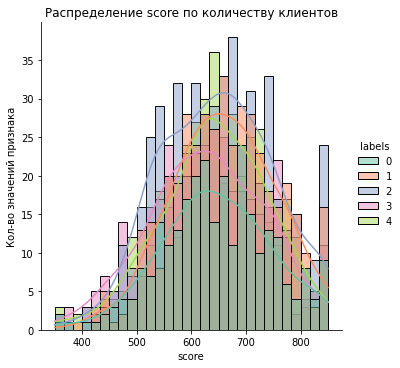

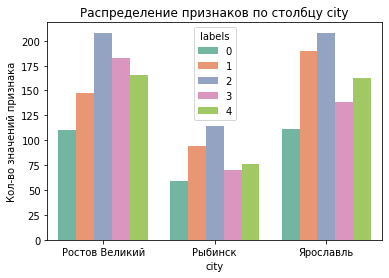

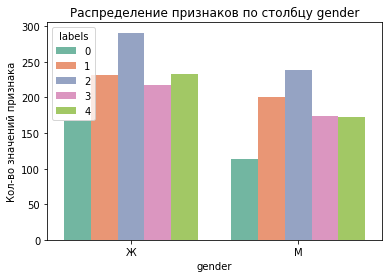

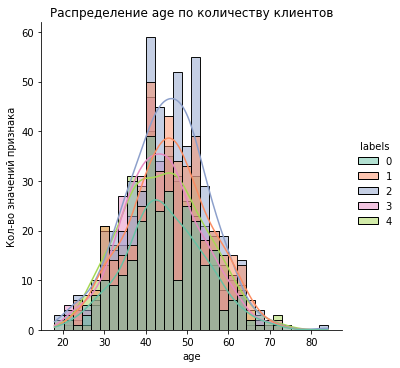

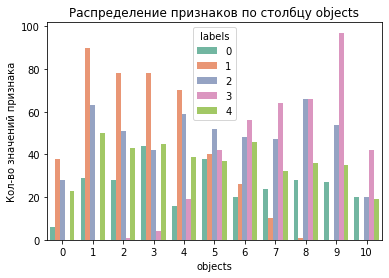

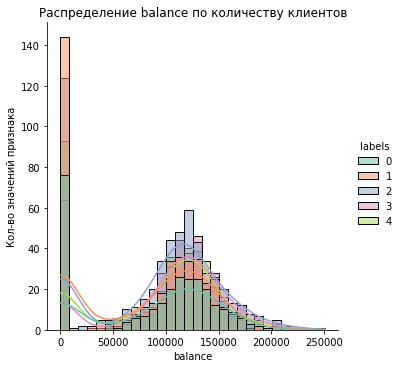

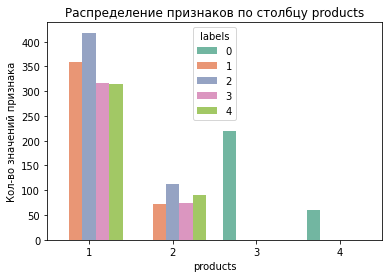

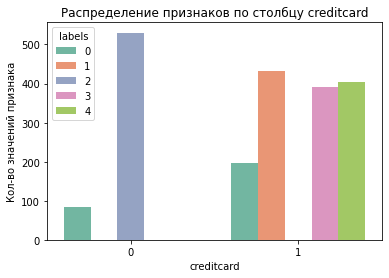

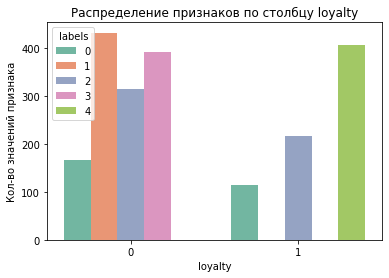

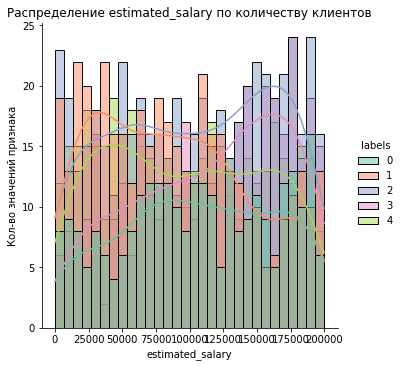

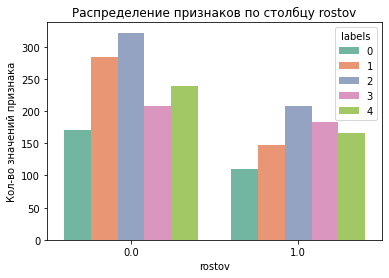

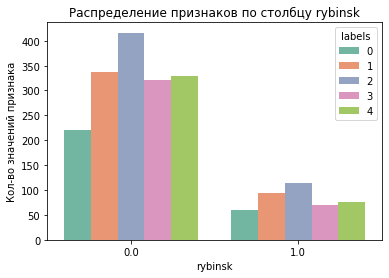

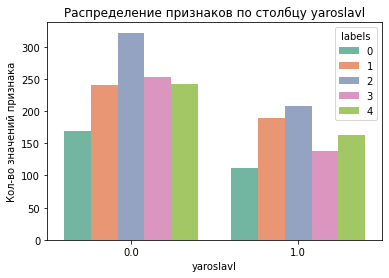

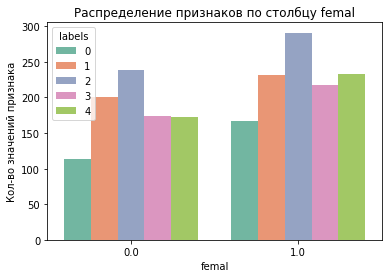

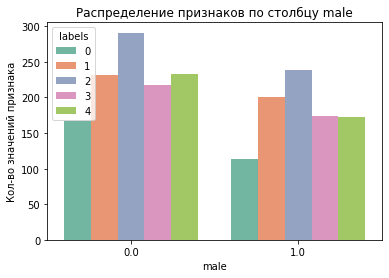

In [ ]:
df_without_labels = df_1.drop(['userid', 'churn', 'labels'], axis=1)

for col in df_without_labels.columns:
    if len(df_without_labels[col].unique().tolist())<=12:
        report = df_1.pivot_table(index=[col, 'labels'], values='userid', aggfunc='count').reset_index()
        sns.barplot (data=report, x=col, y='userid', hue='labels', palette='Set2')
        plt.title('Распределение признаков по столбцу {0}'.format(col))
        plt.ylabel('Кол-во значений признака')
        plt.show()
    else:
        report = df_1.pivot_table(index=[col, 'labels'], values='userid', aggfunc='count').reset_index()
        sns.displot(data=df_1, x=col, hue='labels', kde=True, palette='Set2', bins=30)
        plt.xlabel(col)
        plt.ylabel('Кол-во значений признака')
        plt.title('Распределение {0} по количеству клиентов'.format(col))
        plt.show()

Исходя из средних данных по кластерам и визуализации распределений кластеров по признакам, мы видим, что:
- <b>1 кластер</b> — пользуются наибольшим количеством продуктов банка в среднем, но при этом обладают второй самой маленькой ожидаемой зарплатой (<b>"любители банковских продуктов"</b>. Их меньше всего);<br>
<br>
- <b>2 кластер</b> — наибольший средний возраст, наименьшее количество объектов в собственности, самый маленькие средний баланса на счету и ожидаемая зарплата. При этом они пользуются кредитными картами, но они не совершают действий с банком (нелояльны) (<b>"любители кредиток"</b>);<br>
<br>
- <b>3 кластер</b> — не смотря на то, что среди клиентов 3 кластера наибольшее количество людей с большим количеством объектов, среднее их количество близко к 1 кластеру. При этом они пользуются преимущественно всего 1 продуктом банка и не имеют кредитных карт (<b>"без кредиток"</b>);<br>
<br>
- <b>4 кластер</b> — наименьший средний возраст, но при этом наибольшее количество в среднем объектов в собственности и самые большие средние балансы на счету и ожидаемые зарплаты. Имеют кредитки (<b>"состоятельные"</b>);<br>
<br>
- <b>5 кластер</b> — совершали какое-либо действие недавно (лояльны), имеют кредитки, пользуются одним продуктом (<b>"лояльны, но ушли"</b>). Возможно, это связано с ошибкой в системе, которая не передала ещё вовремя данные

Дополнительно хочется заметить распределение кластеров по городам и полу. Из графиков визуализации можно заметит, что:
- В Ярославле больше всего представителей 2 и 3 кластера ;
- В Ростове Великом — 3, 4 и 5 кластера;
- В Рыбинске 3 кластера. 
- Среди женщин преобладают представители 2, 3 и 5 кластера;
- А у мужчин к этой тройке добавляется ещё и 4 кластер, на равне с 5-м.

Такое попадание 3 кластера во все категории не удивительно, ведь их больше всего среди клиентов.

## Проверка статистических гипотез 

Теперь приступим к проверке двух гипотез, которые мы опредили в начале анализа:<br>
1) Средний уровень дохода у тех клиентов банка, кто остался, отличается от среднего уровня дохода у клиентов банка, которые ушли;<br>
2) Среднее количество продуктов, которыми пользуются клиенты, отличается у группы тех, кто ушел, и группы тех, кто остается с банком.

In [ ]:
#создадим два датасета с оставшимися и ушедшими клиентами, чтобы сравнивать их средние
data0 = df.query('churn==0')
data1 = df.query('churn==1')

#Гипотеза Н0: Средний уровень доходов у оставшихся клиентов банка не отличается от среднего уровня дохода ушедших клиентов банка
#Гипотеза Н1: Средний уровень доходов у оставшихся клиентов банка отличается от среднего уровня дохода ушедших клиентов банка

#задаем уровень значимости для проверки гипотезы 5%, так как гипотеза двухсторонняя
alpha = 0.05

results = st.ttest_ind (data1['estimated_salary'], data0['estimated_salary'], equal_var =  False)

print('p-значение: {:.5f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22892
Не получилось отвергнуть нулевую гипотезу


In [ ]:
#Теперь проверим вторую гипотезу
#H0: Среднее количество продуктов, которыми пользуются ушедшие клиенты, не отличается 
#от среднего кол-ва продуктов, которыми пользуются оставшиеся клиенты;
#H1: Среднее количество продуктов, которыми пользуются ушедшие клиенты, отличается 
#от среднего кол-ва продуктов, которыми пользуются оставшиеся клиенты;

#задаем уровень значимости для проверки второй гипотезы 5%, так как гипотеза двухсторонняя
alpha = 0.05

results = st.ttest_ind (data1['products'], data0['products'], equal_var =  False)

print('p-значение: {:.5f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00022
Отвергаем нулевую гипотезу


Дополнительно мы решили проверить гипотезу о том, что средний возраст клиентов, которые ушли отличается, от среднего возраста оставшихся клиентов.

In [ ]:
#H0: Средний возраст ушедших клиенты не отличается от среднего возраста тех, кто остался;
#H1: Средний возраст ушедших клиенты отличается от среднего возраста тех, кто остался;

alpha = 0.05

results = st.ttest_ind (data1['age'], data0['age'], equal_var =  False)

print('p-значение: {:.5f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00000
Отвергаем нулевую гипотезу


Таким образом, получается, что у ушедших клиентов и оставшихся нет значимого отличия по среднему уровню ожидаемого дохода. При этом эти две группы значимо отличаются по количеству продуктов, которыми пользуются клиенты и среднему возрасту. Как мы видели из распределения средних значений, ушедшие клиенты в среднем обладали большим возрастом и пользовались меньшим кол-во продуктов.

# Выводы

1) Среднестатистический клиент банка — это мужчина из Ярославля, в возрасте около 39 лет, у которого 5 объектов собственности. Он пользуется 1-2 продуктами банка, в том числе кредитной карточкой. На банковском балансе у него около 120 тысяч, при том, что зарабатывает он около 100 тыс.

2) Нужно обратить внимание на пропущенные значения в признаке баланса на счету (36% от общего числа). Их причина не до конца понятна и выглядит подозрительно, что пропущенных значений нет только у клиентов из Ростова Великого. Возможно, что:
- это из-за того, что клиенты появились недавно и поэтому их счет ещё не активировали и там ничего нет. Но тогда не понятно, как клиент мог уже совершить какое-то действие (признак лояльности) и даже уйти из банка).
- это из-за проблем в системе, которая считает 0 на счету — как то, что нет денег (что в целом логично). Однако тогда получается, что у более 30% (и оставшихся, и ушедших) клиентов банка на балансе счета — 0. <br>
<br>
Необходимо проверить дополнительно то, как данные попадают в признак баланса. Например, запросив данные об открытии клиентов счета в банке и дате ухода из банка.<br>

3) Особенностями, которые отличают группы ушедших и оставшихся клиентов заключаются:
- в возрасте (хоть среди молодых людей и много тех, кто уходит, средний возраст оставшихся клиентов меньше) и в использовании банковских карточек (те, кто пользуются кредитными картами, уходят чаще, чем те, у кого нет кредиток)
- проверка статистических гипотез показала, что группы значимо отличаются по среднему возрасту и количеству используемых продуктов. Средний доход здесь не играет существенную роль;
- Кроме того, хочется отметить, что на фоне других признаков выделяется то, что клиентов из Ростова Великого уходит почти столько же, сколько из Ярославля, где в 2 раза больше клиентов. Также, женщин уходит почти столько же, сколько мужчин, опять же несмотря на то, что последних больше.

4) Изучение портретов ушедших пользователей позволило выделить 5 типов:<br>
- <b>"Любители банковских продуктов"</b><br>
- <b>"Возрастные любители кредиток"</b><br>
- <b>"Не хотят кредиток"</b><br>
- <b>"Молодые, но хорошо зарабатывающие"</b><br>
- <b>"Лояльные, но ушедшие"</b><br>

5) Мы слабо знакомы с программами и продуктами, которые есть в банке. Для более детальных рекомендаций необходима встреча с отделами маркетинга. В качестве рекомендаций для банка можно предложить:
- <b>Для 1 кластера</b> предусмотреть регулярные акции и напоминания о текущих проекта банка, но учитывающие, что это не самые состоятельные клиенты. Например, предусмотреть программы лояльности с местами в городах с небольшим средним чеком. Возможно, количество продуктов — это кличество карт и счетов, которые открыты в банке. Тогда можно предположить, что это люди, которые открывали для продукты для своей семьи;<br><br>
- <b>Для 2 кластера</b> самый популярный продукт — кредитки. Видимо, их уход связан с более выгодными кредитными условиями у конкурентов. Сомнительно, чтобы эта категория людей уезжала в другие города, поэтому стоит рассмотреть кредитные предложения и рассрочки, которые предлагают банки в Ярославле, Рыбинске и Ростове Великом. Кроме того, можно предположить, что это люди, которые чаще других ездят на общественном транспорте, с которым тоже можно придумать совместные программы;<br><br>
- <b>Для 3 кластера</b> необходимо акцентировать внимание на продуктах банка, которые программах лояльности для дебитовых карт и не связаны с кредитами;<br><br>
- <b>Для 4 кластера</b> лучше всего будет создать программы лояльности и партнёрств с местами в городах, где цены выше среднего. Возможно, эта категория людей выбирается из городов чаще остальных в силу финансовых возможностей, так что, может быть, им была бы интересна сфера, связанная с путешествиями и бонусами от заправки / вождения машин / бронирования жилья;<br><br>
- <b>Для 5 кластера</b> в первую очередь необходимо проверить корректность и состыковку работы алгоритмов передающих друг другу данные, так как история с тем, кто клиент лоялен, но ушел выглядит не совсем правдоподобной.